# Trabalho Prático 1 - Algoritmos 2 2024.1 UFMG
Membros:

* Gabriel Arcanjo Campelo Fadoul - 2021031645
* Mateus Gonçalves Moreira - 2022035610
* Victor Augusto Hon Fonseca - 2022035814

# O Problema da Galeria de Arte

Esse é um tipo de problema de otimização que busca minimizar, a partir da planta de uma galeria de arte descrita como um polígono, a quantidade de câmeras necessárias para que todos cômodos da propriedade sejam cobertos. Iremos utilizar instâncias disponibilizadas por pesquisadores da Universidade Estadual de Campinas(UNICAMP) no seguinte site: https://www.ic.unicamp.br/~cid/Problem-instances/Art-Gallery/AGPVG/index.html

In [3]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from TriangProntaAlterada import *

## Carga das instâncias de testes

Inicializamos montando um pequeno script que consegue consumir as instâncias de acordo com sua respectiva formatação e converte os valores para a nossa estrutura de dados

In [4]:
with open("instances\\agp2009a-orthorand\\agp2009a-orthorand\\random-20-5.pol") as f:
    line = f.readline()
    file_values = line.split()
total_vertices = int(file_values[0])

G = Grafo()

V = []
for i in range(1,len(file_values),2):
    X, Y = file_values[i], file_values[i+1]
    
    a, b = X.split("/")
    coord_x = float(a) / float(b)
    
    a, b = Y.split("/")
    coord_y = float(a) / float(b)
    
    V.append(Vertice(coord_x, coord_y))
    G.adicionar_vertice(Vertice(coord_x, coord_y))

for i in range(len(V)-1):
    G.adicionar_aresta(Aresta(G.vertices[i],G.vertices[i+1]))

G.adicionar_aresta(Aresta(G.vertices[len(V)-1],G.vertices[0]))

**Segue uma amostra de como é o formato do polígono carregado que representa a planta da galeria de arte:**

In [5]:
v = list(map(lambda P: (P.x,P.y),G.vertices))
v.append(v[0]) # Repete primeiro vértice ao final para fechar o polígono

fig = px.line(x=np.array(v)[:,0],y=np.array(v)[:,1],markers=True, width=900, height=700)
fig.update_traces(marker_size=10)
fig.show()

## Triangulação

O algoritmo de triangulação implementado é o algortimo conhecido como **Ear Clipping**, ele utiliza as primitivas de checagem se dois vetores estão numa orienção horária, anti-horária ou colineares. Essa primitiva irá ajudar a identificar se um ponto é carcterizado como uma ponta de orelha. Uma ponta de orelha é um ponto cujo vetor formado pelo seu antecessor e ele; juntamente com o vetor formado pelo ponto e seu sucessor possuem uma orientação anti-horária. Além disso, não deve possuir nenhum outro ponto dentro do triangulo formado por esses três pontos.

A partir do momento em que um ponto é identificado como uma ponta de orelha, ele é "removido" do polígono, é criada uma nova aresta entre o ponto anterior e o sucessor; e seus vizinhos são atualizados. O algoritmo continua executando sucessivamente em todos os pontos até o momento em que sobram somente três pontos formando um triângulo.

Esse processo será visível através da animação desenvolvida neste trabalho.

In [6]:
# Copia o grafo original para evitar mudanças "inplace"
triang_graph = Grafo()
triang_graph.graph = G.graph.copy()
triang_graph.arestas = G.arestas.copy()
triang_graph.vertices = G.vertices.copy()

verticesAnimacao = list(triang_graph.vertices)
verticesAnimacao.append(triang_graph.vertices[0])
start_step = list(map(lambda P: (P.x,P.y), verticesAnimacao))
(triang_graph, triangulos, polygon_stages, steps) = triangulacao(triang_graph, [start_step], [])

In [12]:
v = list(map(lambda P: (P.x,P.y), triang_graph.vertices))
v.append(v[0])

x_v, y_v = zip(*v)
x_v, y_v = list(x_v), list(y_v)
xMin, yMin = min(x_v) - 2, min(y_v) - 2
xMax, yMax = max(x_v) + 2, max(y_v) + 2


# Criação da estrutura da figura
fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

# Configuração do layout
fig_dict["layout"]["title"] = "Execução do Algoritmo de Ear Clipping"
fig_dict["layout"]["width"] = 900 
fig_dict["layout"]["height"] = 700
fig_dict["layout"]["xaxis"] = {"range": [xMin, xMax], "title": "X"}
fig_dict["layout"]["yaxis"] = {"range": [yMin, yMax], "title": "Y"}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 500, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Stage:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

# Configuração inicial do polígono
initial_polygon = polygon_stages[0]
x, y = zip(*initial_polygon)
colors = ['blue'] * (len(x) - 1) + ['red']  # Último ponto em vermelho
data_dict = {
    "x": x,
    "y": y,
    "mode": "lines+markers",
    "marker": {"color": colors},
    "name": "Polygon",
    "line": {"shape": "linear"}
}
fig_dict["data"].append(data_dict)

# Criação dos frames para cada estágio do polígono
for i, step  in enumerate(steps):
    frame = {"data": [], "name": str(step)}
    polygon = polygon_stages[i]
    x, y = zip(*polygon)
    colors = ['blue'] * (len(x) - 1) + ['red']  # Último ponto em vermelho
    data_dict = {
        "x": x,
        "y": y,
        "mode": "lines+markers",
        "marker": {"color": colors, "size": [10] * (len(x) - 1) + [15] },
        "name": "Polygon",
        "line": {"shape": "linear"}
    }
    frame["data"].append(data_dict)
    fig_dict["frames"].append(frame)

    slider_step = {
        "args": [
            [step],
            {"frame": {"duration": 300, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 300}}
        ],
        "label": step,
        "method": "animate"
    }
    sliders_dict["steps"].append(slider_step)

fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.show()

## Coloração

O algoritmo de coloração será utilizado para verificar em quais vétices será colocado uma câmera, ele utiliza do gráfico já triangularizado. O problema de coloração de grafos é um problema famosamente conhecido por ser NP-Completo, logo não é viável a utilização de uma aborgadem tradicional de coloração. Porém, o nosso problema possui características que possibilitam a otimização do processo, transformando-o em Linear. 

Tendo a sequência de triangulos, é possivel a montagem de um grafo Dual, em que cada triângulo é representado por um vértice e caso o triângulo compartilhe dois vértices com outro triângulo(sejam vizinhos), ele terá uma aresta no grafo dual representando essa adjacência.

### Script de Criação do Dual

In [13]:
colored_Graph = G.graph.copy()

dual = nx.Graph()
for i in range(len(triangulos)):
    tri_v = '-'.join(np.array(triangulos[i],dtype=str))
    dual.add_node(i,tri_v = tri_v)

for i in range(len(triangulos)):
    for j in range(len(triangulos)):
        if(len(set(triangulos[i]+triangulos[j]))) == 4:
            dual.add_edge(i,j)

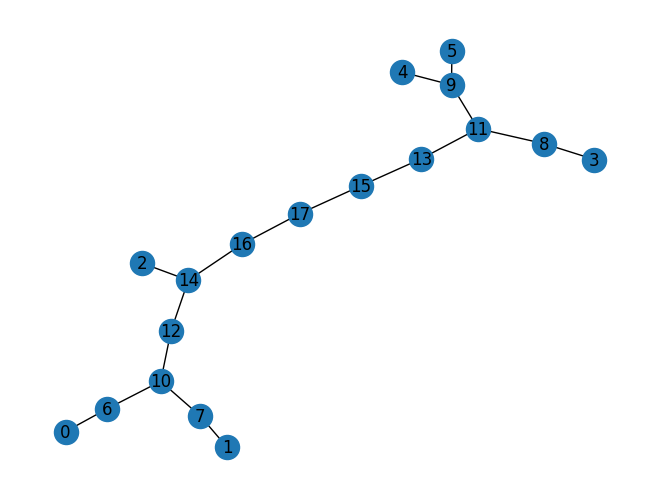

In [14]:
nx.draw(dual, with_labels=True)

O Grafo Dual é uma árvore, nos possibilitando fazer uma busca em profundidade em complexidade de tempo O(N), mantendo a Linearidade. Essa busca em profundidade vai nos possibilitar uma ordem de coloração de cada triângulos, podendo inicializar em qualquer triângulo arbitrariamente. Ao colorir o primeiro com três cores, segue para o vizinho, colorindo o único vértice não pintado e usando a única cor que é permitida, realizando essa operação sucessivamente, teremos uma 3-Coloração em tempo O(N). É possivel visualizar esse processo com a animação abaixo(A cor azul está sendo utilizada significando a não coloração do vértice).

In [15]:
dfs_edges = list(nx.dfs_edges(dual))
colored_Graph, act_s = color_triangle(colored_Graph,triangulos,0)
stages = [act_s]
for i,j in dfs_edges:
    colored_Graph, act_s = color_triangle(colored_Graph,triangulos,j)
    stages.append(act_s)

In [18]:

fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

# Configuração do layout
fig_dict["layout"]["title"] = "Execução do Algoritmo de Coloração em Cada Triângulo"
fig_dict["layout"]["width"] = 900 
fig_dict["layout"]["height"] = 700
fig_dict["layout"]["xaxis"] = {"range": [xMin, xMax], "title": "X"}
fig_dict["layout"]["yaxis"] = {"range": [yMin, yMax], "title": "Y"}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 500, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Stage:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

# Configuração inicial do polígono
initial_polygon = polygon_stages[-1]
x, y = zip(*initial_polygon)

colors = ['blue'] * (len(x))
data_dict = {
    "x": x,
    "y": y,
    "mode": "lines+markers",
    "marker": {"color": colors, "size": 15},
    "name": "Polygon",
    "line": {"shape": "linear"}
}
fig_dict["data"].append(data_dict)

# Criação dos frames para cada estágio do polígono
for i, stage in enumerate(stages):
    frame = {"data": [], "name": str(i)}
    mapping_colors = np.array(stages[i])[list(map(lambda x: list(nx.get_node_attributes(colored_Graph, 'pos').values()).index(x), polygon_stages[-1]))]
    colors = ['blue' if c == None else c for c in mapping_colors]
    data_dict = {
        "x": x,
        "y": y,
        "mode": "lines+markers",
        "marker": {"color": colors, "size": 15},
        "name": "Polygon",
        "line": {"shape": "linear"}
    }
    frame["data"].append(data_dict)
    fig_dict["frames"].append(frame)

    slider_step = {
        "args": [
            [i],
            {"frame": {"duration": 300, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 300}}
        ],
        "label": i,
        "method": "animate"
    }
    sliders_dict["steps"].append(slider_step)

fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.show()

## Resposta Final

A resposta final é dada ao colocar as câmeras nos vértices que estão coloridos com a cor que possui a menor quantidade de vértices pintados com ela.

In [17]:
color, counts = np.unique(stages[-1],return_counts=True)
for i in range(len(color)):
    print(f"Há {counts[i]} vértices com a cor {color[i]}")
    
print(f"\n Logo a resposta final são {min(counts)} câmeras colocadas sobre os vértices de cor {color[np.where(counts == min(counts))][0]}")

Há 7 vértices com a cor green
Há 7 vértices com a cor red
Há 6 vértices com a cor yellow

 Logo a resposta final são 6 câmeras colocadas sobre os vértices de cor yellow
